In [ ]:
import sys 
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
import warnings
import tensorflow as tf

from utils import *

from sensor_params import *


from evaluation.single_step.evaluation import model_evaluation_refeed as single_step_model_evaluation_refeed
from evaluation.multi_step.evaluation import model_evaluation_refeed as multi_step_model_evaluation_refeed

sys.path.append('..')

# Dataset path 
DATABASE_PATH = r"C:\Users\aralmeida\OneDrive - Universidad de Las Palmas de Gran Canaria\Doctorado\Bases de datos\WARIFA\Mikael T1DM"

filename = "MIKAEL_data.json"

parent_directory = r"C:\Users\aralmeida\Downloads"
experiments_folder = r"\T1DM_pred_experiments"

# Load data from the json file. If executed, comment the line and load the data from the pickle file
# data , basal_data_dict, blood_pressure_dict, bolus_data_dict, exercise_data_dict, carbohydrates_data_dict, pump_events_data_dict, sgv_data_dict, sleep_data_dict, smgb_data_dict, steps_data_dict, weight_dict  = extract_Mikael_data(DATABASE_PATH, filename, ONLY_CGM = True)
with open(DATABASE_PATH+'\CGM.pk1', 'rb') as f:
    sgv_data_dict = pickle.load(f)
os.chdir(parent_directory)


## Single point Refeed

In [ ]:
N=48
step=1
PH=5

# Generate the single point prediction dataset
X, Y, X_times, Y_times = get_CGM_X_Y(sgv_data_dict, sensor_Mikael, N, step, PH, experiments_folder, plot=False, verbose = 0)

# Min-max normalization
X_norm = (X - np.min(X))/(np.max(X) - np.min(X))
Y_norm = (Y - np.min(X))/(np.max(X) - np.min(X))

# Make partition
X_train = X_norm[np.where(X_times[:,N-1] <= pd.to_datetime('2021-05-31 00:00:00'))[0]]
Y_train = Y_norm[np.where((Y_times[:,0] < pd.to_datetime('2021-05-30 23:59:59')))[0]]
X_test = X_norm[np.where((X_times[:,N-1] > pd.to_datetime('2021-06-01 00:00:00')))[0]]
Y_test = Y_norm[np.where((Y_times[:,0] > pd.to_datetime('2021-06-01 00:00:00')))[0]] # Left non-normalized to compute the metrics

# Load a single point prediction model
model = tf.keras.models.load_model(r"C:\Users\aralmeida\Downloads\T1DM_pred_experiments\mikael_sensor\N48\step1\PH5\single\june-21\norm_min-max\under_sampling\StackedLSTM\training\StackedLSTM.h5") 

In [ ]:
close_loop_iterations = 30
predictions = 1000

# Create empty numpy 
Y_pred_norm_normal = np.empty((0))

# Loop to iterate over all the X test vector with jumps equal to the close loop iterations
# for i in range(0, 1000, close_loop_iterations):
for i in range(0, predictions):

    input_seq = X_test[i].reshape(1,N,1)
                       
    # Model prediction 
    pred = model.predict(input_seq)

    # Add the prediction to the Y_pred_norm vector
    Y_pred_norm_normal = np.append(Y_pred_norm_normal, pred)

# Denorm
Y_pred_normal = Y_pred_norm_normal*(np.max(X) - np.min(X)) + np.min(X)
X_test_denorm = X_test*(np.max(X) - np.min(X)) + np.min(X)
Y_test_denorm = Y_test*(np.max(X) - np.min(X)) + np.min(X)

In [ ]:
# Create empty numpy 
Y_pred_norm = np.empty((0))

# What will be the evaluation_refeed function 

# Loop to iterate over all the X test vector with jumps equal to the close loop iterations
# for i in range(0, 1000, close_loop_iterations):
for i in range(0, predictions, close_loop_iterations):

    # Loop to generate one prediction at a time and make that prediction to be the last sample of the input sequence. 
    for j in range(0, close_loop_iterations): 

        # When entering the loop, the input sequence is the full of the X_test vector
        if j == 0:
            input_seq = X_test[i+j].reshape(1,N,1)
        else:
            # Shift to the left the input sequence
            input_seq = np.roll(input_seq, -1, axis=1)

            # Replace last element with the prediction
            input_seq[0][N-1] = pred

            # Reshape to fit the Keras call
            input_seq = input_seq.reshape(1,N,1)
              
        # Model prediction 
        pred = model.predict(input_seq)

        print("Prev sample: ", X_test[i+j][len(X_test[i+j])-1])
        print("Prediction: ", pred)

        # Add the prediction to the Y_pred_norm vector
        Y_pred_norm = np.append(Y_pred_norm, pred)

In [ ]:
X_test.shape

In [ ]:
model.layers[0].input_shape

In [ ]:
# Denorm
Y_pred = Y_pred_norm*(np.max(X) - np.min(X)) + np.min(X)
X_test_denorm = X_test*(np.max(X) - np.min(X)) + np.min(X)
Y_test_denorm = Y_test*(np.max(X) - np.min(X)) + np.min(X)

In [ ]:
# Figure 1, with the normal prediction
plt.plot(Y_pred_normal, label="Normal prediction")
plt.plot(Y_test_denorm[0:predictions,:], label="Ground truth")
plt.title("Normal prediction")

# Plot a vertical line every close loop iteration
for i in range(0, predictions, close_loop_iterations):
    plt.axvline(x=i, color='r', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig("normal_prediction.png", dpi=300)

plt.figure()
plt.plot(Y_pred, label="Prediction")
plt.plot(Y_test_denorm[0:predictions,:], label="Ground truth")
plt.title("Close loop prediction")

# Plot a vertical line every close loop iteration
for i in range(0, predictions, close_loop_iterations):
    plt.axvline(x=i, color='r', linestyle='-', linewidth=0.5)

plt.legend()
plt.savefig("close_loop_prediction.png", dpi=300)

## Seq-to-Seq Refeed

In [ ]:
N=144
step=1
PH=60
sensor = sensor_Mikael


# Generate the seq-to-seq prediction dataset
X, Y, X_times, Y_times = get_CGM_X_Y_multistep(sgv_data_dict, sensor_Mikael, N, step, PH, experiments_folder, plot=False, verbose = 0)  

# Min-max normalization
X_norm = (X - np.min(X))/(np.max(X) - np.min(X))
Y_norm = (Y - np.min(X))/(np.max(X) - np.min(X))

# Make partition
X_train = X_norm[np.where(X_times[:,N-1] <= pd.to_datetime('2021-05-31 00:00:00'))[0]]
Y_train = Y_norm[np.where((Y_times[:,0] < pd.to_datetime('2021-05-30 23:59:59')))[0]]
X_test = X_norm[np.where((X_times[:,N-1] > pd.to_datetime('2021-06-01 00:00:00')))[0]]
Y_test = Y_norm[np.where((Y_times[:,0] > pd.to_datetime('2021-06-01 00:00:00')))[0]] # Left non-normalized to compute the metrics

# Load a seq-to-seq- prediction model 
s2s_model = tf.keras.models.load_model(r"C:\Users\aralmeida\Downloads\T1DM_pred_experiments\N144_stride1_step12\training\StackedLSTM-minmax-himar-rep.h5")

In [230]:
num_predictions = 5
predictions_normal = np.empty((num_predictions, round(PH/sensor["SAMPLE_PERIOD"])))
# What will be the evaluation_refeed function 
# Model prediction 
#Y_pred_norm = s2s_model.predict(X_test.reshape(1,N,1))


for i in range(0,num_predictions):
# Normal seq2seq prediction
    Y_pred_norm = s2s_model.predict(X_test[0].reshape(1,N,1))

    predictions_normal[i] = Y_pred_norm

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


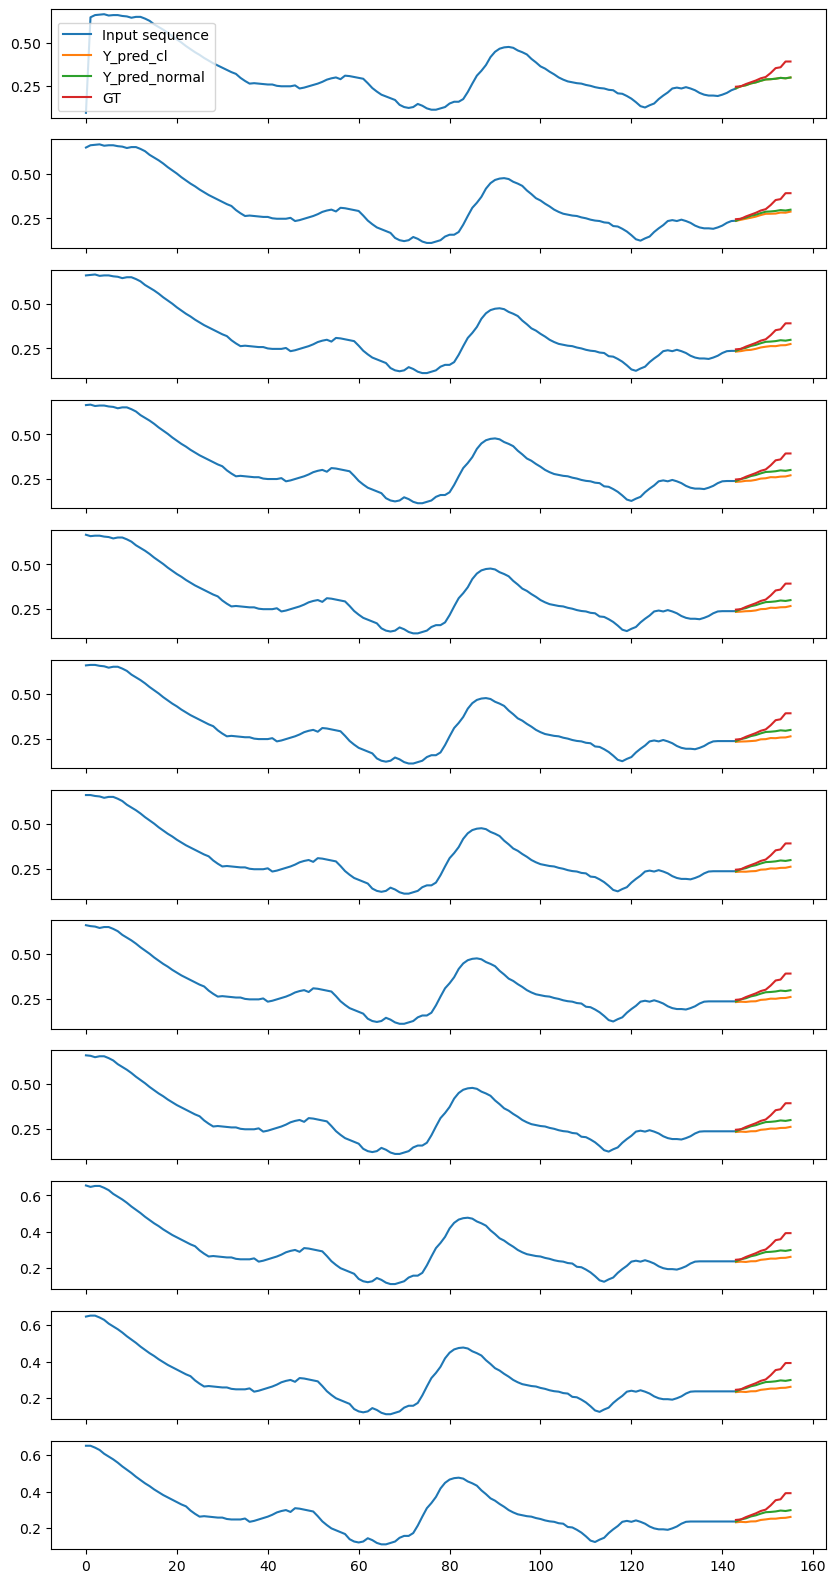

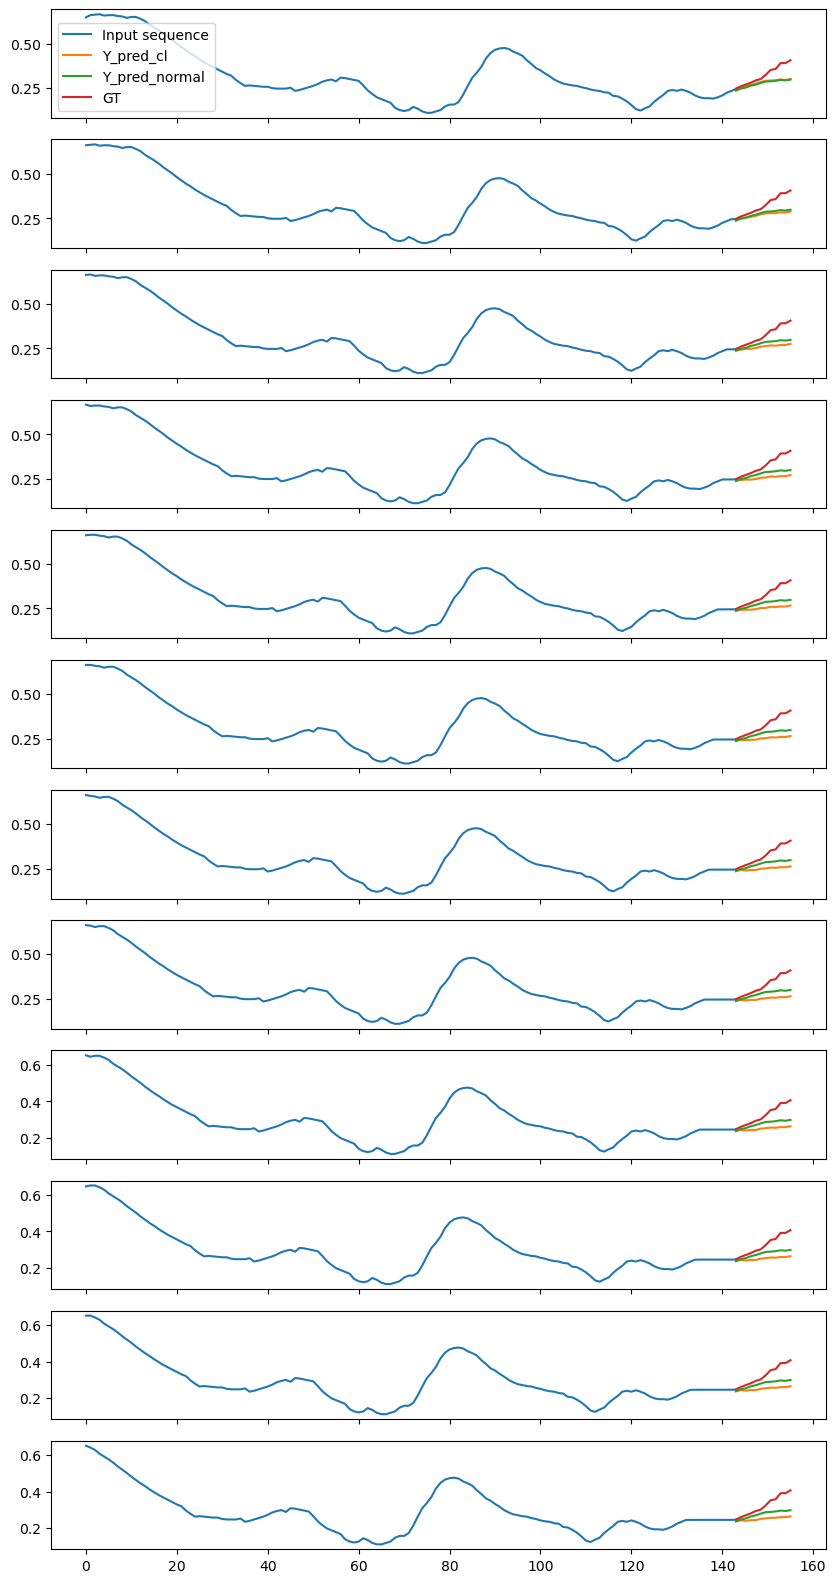

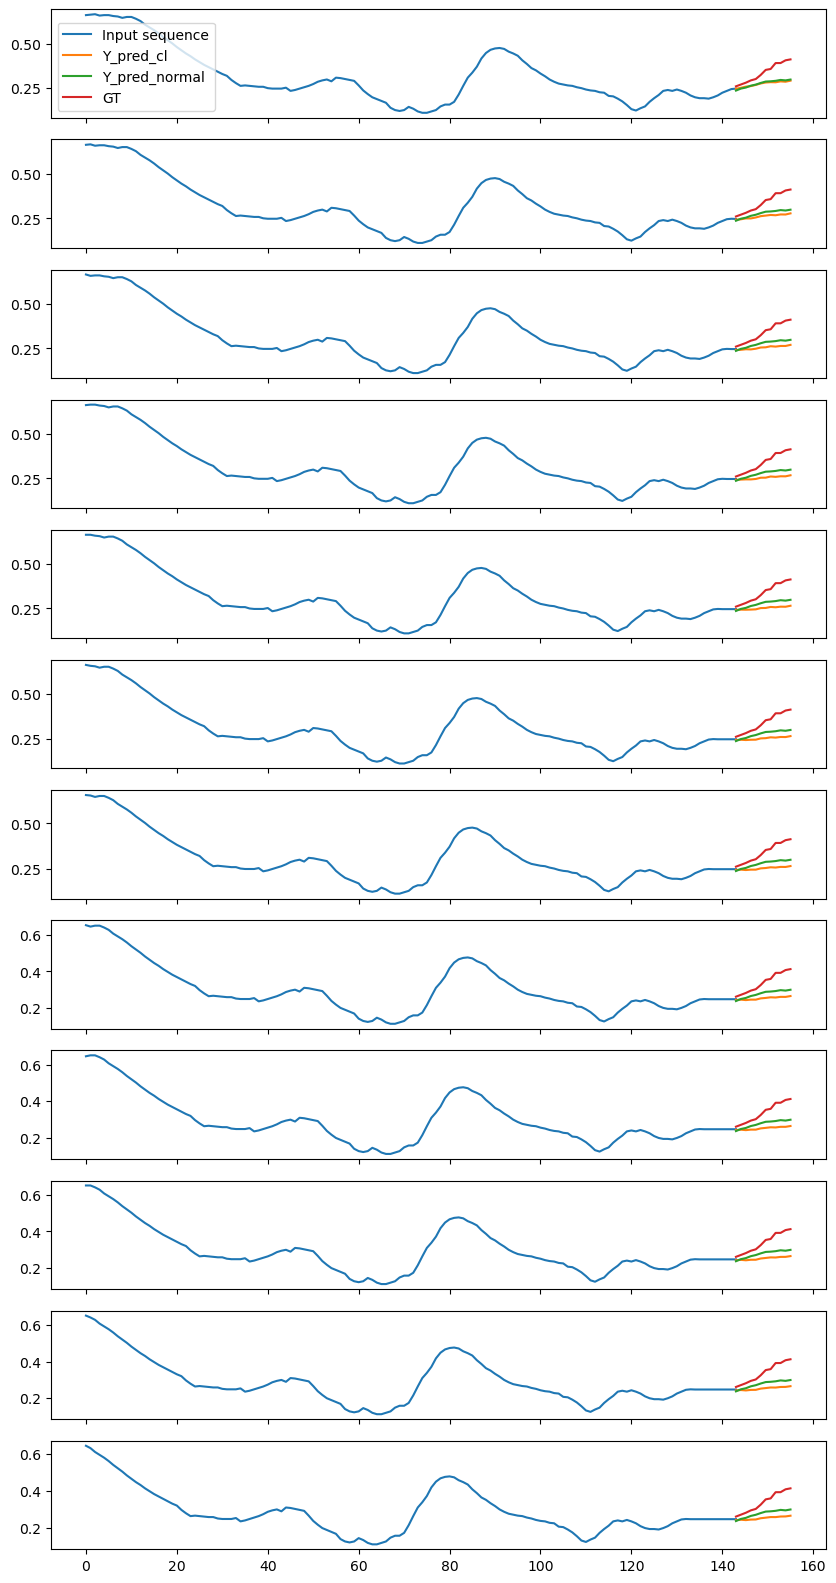

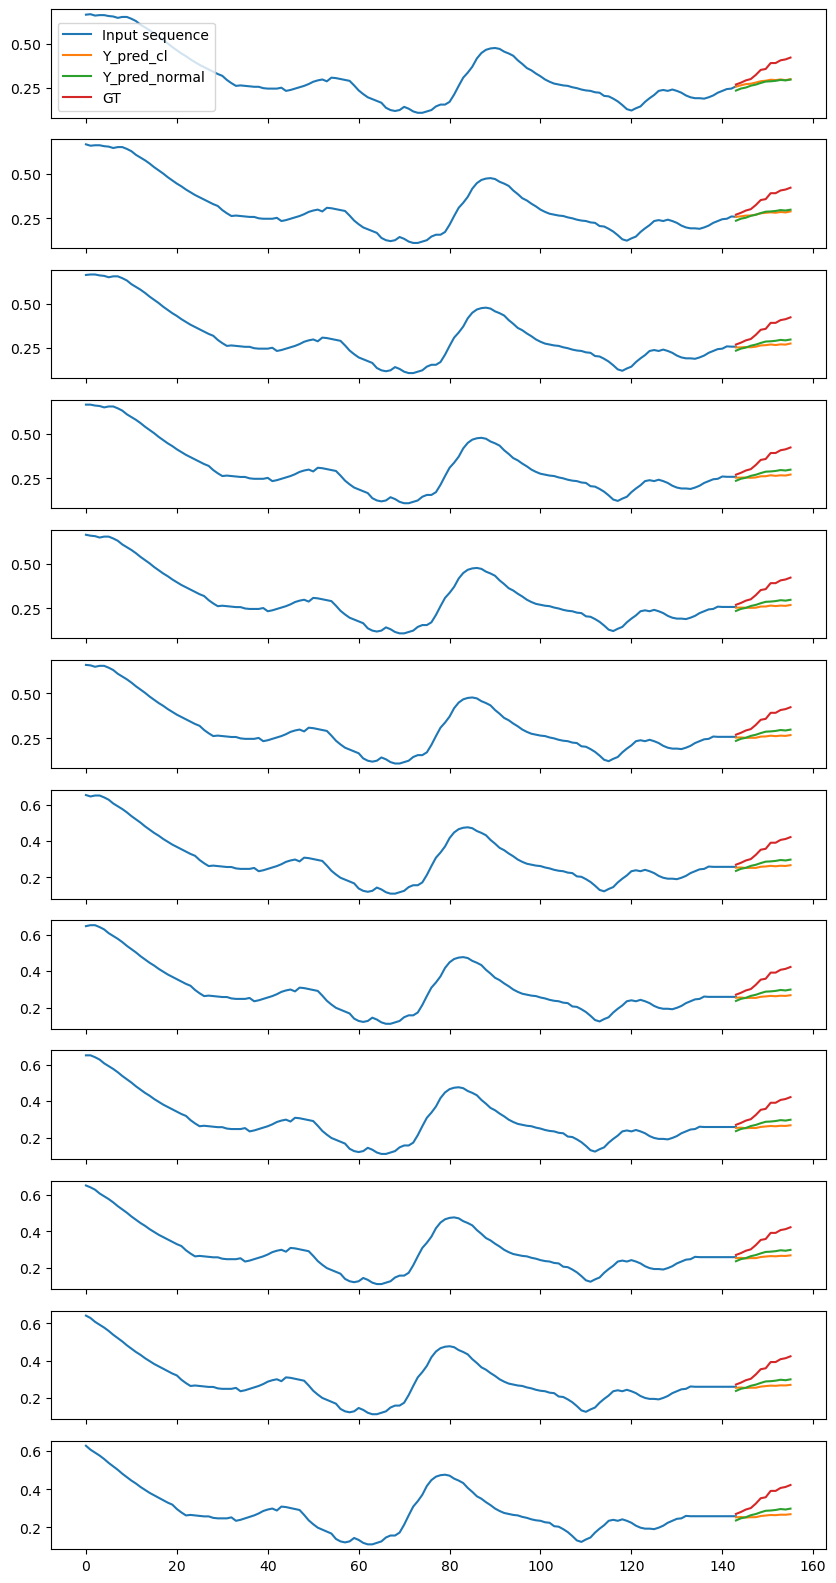

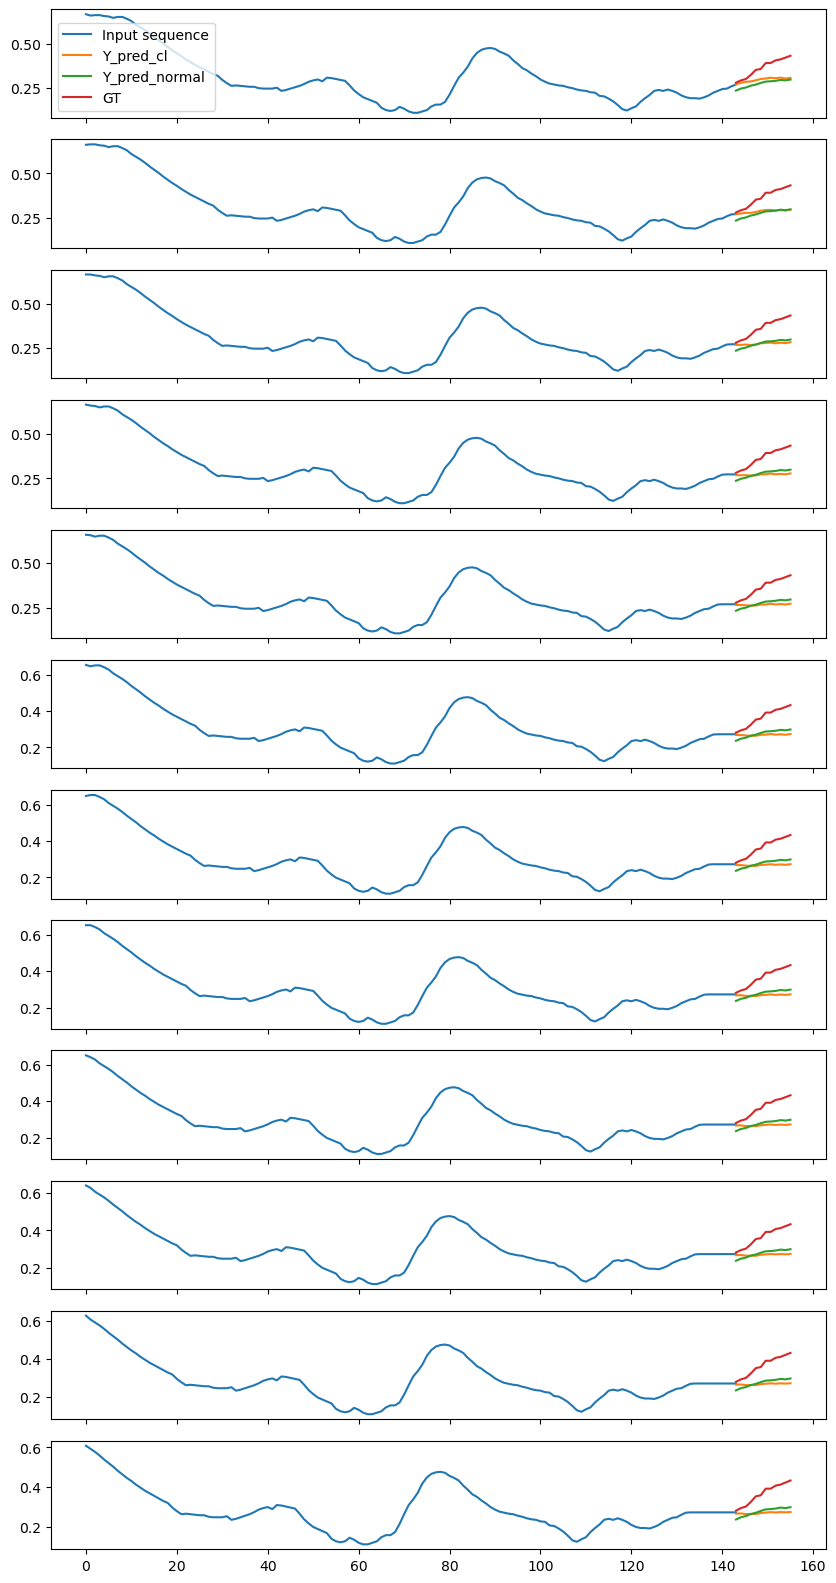

In [242]:
predictions_cl = np.empty((num_predictions, round(PH/sensor["SAMPLE_PERIOD"])))

# Iterate over a certain number of predictions 
for i in range(0, num_predictions): 

    # Loop of cloose loop iterations 
    output_seq = np.empty((round(PH/sensor["SAMPLE_PERIOD"])))

    # Figure of 12 x 1 subplots
    fig, axs = plt.subplots(12, 1, figsize=(10, 20), sharex=True)

    # Loop to make a number of predictions equal to the output lenght, being the final sequence the first sample of each prediction
    for j in range(0, len(output_seq)):

        # If it is the first iteration, the input sequence is the full X_test vector
        if j == 0: 
            input_sequence = X_test[i].reshape(1,N,1)

        # If it is not the first iteration, the input sequence is shifted and the last element is the first element of the predicted output sequence
        else:
            input_sequence = np.roll(input_sequence, -1, axis=1)
            input_sequence[0][N-1] = output_seq[0]
        
        # Model prediction 
        pred = s2s_model.predict(input_sequence)

        # Plot the input sequence and the output sequence in the plot i
        axs[j].plot(input_sequence[0], label="Input sequence")
        axs[j].plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), pred.reshape(12,), label = 'Y_pred_cl')
        axs[j].plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), predictions_normal[i].reshape(12,), label = 'Y_pred_normal')
        axs[j].plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), Y_test[i].reshape(12,), label = 'GT')

        if j==0:
            axs[j].legend()
            

        

        output_seq[j] = pred[0][0]
    
    predictions_cl[i] = output_seq

In [235]:
predictions_cl[1]

array([0.24517509, 0.24381499, 0.24076772, 0.24033295, 0.2408648 ,
       0.24106993, 0.24106149, 0.24103633, 0.24094504, 0.24075808,
       0.24052578, 0.24029852])

In [236]:
predictions_normal[0]

array([0.23622248, 0.24762672, 0.2534427 , 0.26392642, 0.2700651 ,
       0.27937785, 0.28728092, 0.28869736, 0.2914111 , 0.29638359,
       0.29385853, 0.29851568])

In [237]:
# Denorm
Y_pred = Y_pred_norm*(np.max(X) - np.min(X)) + np.min(X)
X_test_denorm = X_test*(np.max(X) - np.min(X)) + np.min(X)
Y_test_denorm = Y_test*(np.max(X) - np.min(X)) + np.min(X)

predictions_normal_denorm = predictions_normal*(np.max(X) - np.min(X)) + np.min(X)
predictions_cl_denorm = predictions_cl*(np.max(X) - np.min(X)) + np.min(X)

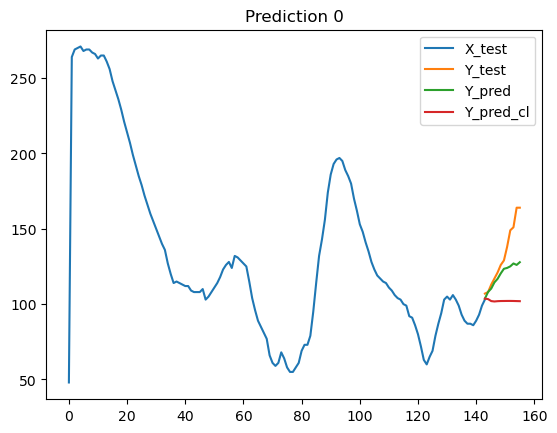

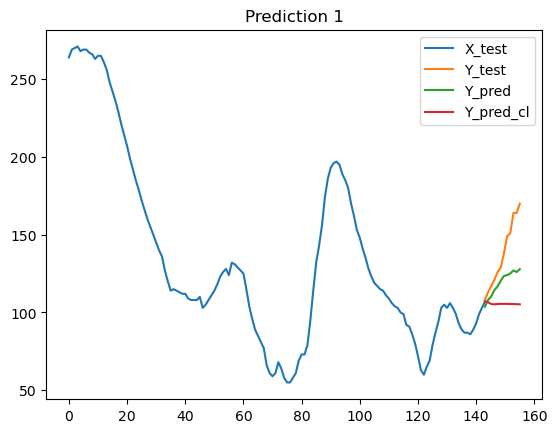

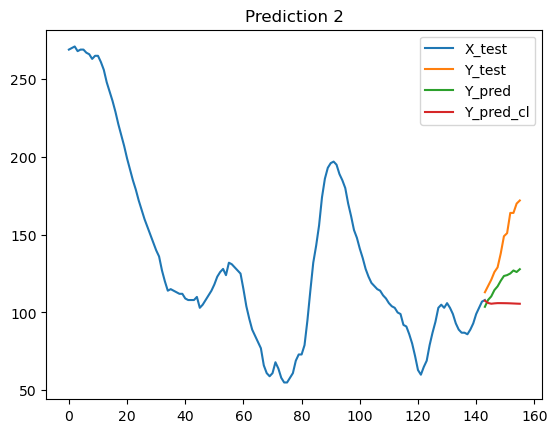

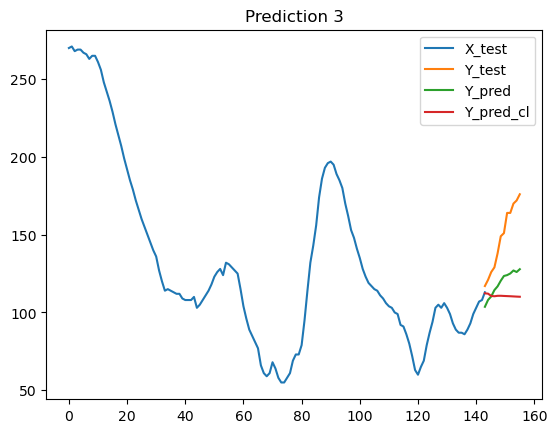

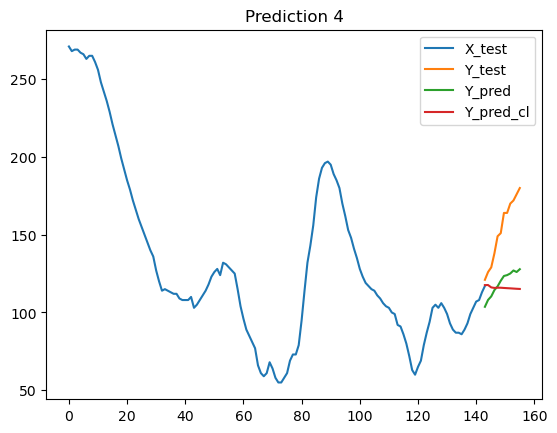

In [238]:
# Plot all predictions 
for i in range(0, num_predictions):

    plt.figure()
    title = "Prediction " + str(i)
    plt.title(title)
    plt.plot(X_test_denorm[i, :], label = 'X_test')
    plt.plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), Y_test_denorm[i, :], label = 'Y_test')
    plt.plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), predictions_normal_denorm[i].reshape(12,), label = 'Y_pred') # for LSTM
    plt.plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), predictions_cl_denorm[i], label = 'Y_pred_cl')
    plt.legend()  

In [ ]:
Y_test[0,:].shape

In [ ]:
Y_pred_norm.shape

# reshape to be (12,)
Y_pred_norm = Y_pred_norm.reshape(12,)

In [ ]:
Y_pred_norm.shape

In [ ]:
output_seq.shape

In [ ]:
output_seq_denorm = output_seq*(np.max(X) - np.min(X)) + np.min(X)

In [ ]:
plt.plot(Y_test[0, :])

In [ ]:
plt.figure()
title = "Prediction " + str(i)
plt.title(title)
plt.plot(X_test_denorm[i, :], label = 'X_test')
plt.plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), Y_test_denorm[0, :], label = 'Y_test')
plt.plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), Y_pred_norm.reshape(12,), label = 'Y_pred_norm') # for LSTM
plt.plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), output_seq_denorm, label = 'Y_pred_cl')
plt.legend()  

In [ ]:
# Testing plots

# Compare the seq-to-seq with the seq-to-seq close loop
plt.figure()
plt.plot(X_test_denorm[i, :], label = 'X_test')
plt.plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), Y_test[i, :], label = 'Y_test')
# plt.plot(np.linspace(143,149, 6), Y_pred[i, 0,:], label = 'Y_pred')
plt.plot(np.linspace(N-1,N-1+round(PH/5), round(PH/5)), Y_pred[i,:], label = 'Y_pred') # for LSTM
plt.legend()
# Save figure
plt.savefig(name+'_sample'+str(i)+'.png', dpi=300, bbox_inches='tight') 